# XGBOOST

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures, DropCorrelatedFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

In [2]:
base_station_info = pd.read_csv('Base Station basic information.csv')
cell_level_data = pd.read_csv('Cell-level data.csv')
energy_consumption_data = pd.read_csv('Energy consumption data.csv')

In [3]:
print('Size of base_station_info', base_station_info.shape)
print('Size of cell_level_data', cell_level_data.shape)
print('Size of energy_consumption_data', energy_consumption_data.shape)

Size of base_station_info (1217, 8)
Size of cell_level_data (125575, 10)
Size of energy_consumption_data (92629, 3)


In [4]:
print('Duplicate of base_station_info', base_station_info.duplicated().sum())
print('Duplicate of cell_level_data', cell_level_data.duplicated().sum())
print('Duplicate of energy_consumption_data', energy_consumption_data.duplicated().sum())

Duplicate of base_station_info 0
Duplicate of cell_level_data 0
Duplicate of energy_consumption_data 0


In [5]:
base_station_info.sample(5)

,BS,CellName,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower
807,B_807,Cell0,Type4,Mode2,532.00,20,2,6.875934
137,B_137,Cell0,Type4,Mode2,532.00,20,2,6.875934
668,B_668,Cell0,Type4,Mode2,532.00,20,2,6.875934
1209,B_820,Cell1,Type1,Mode2,426.98,2,2,7.325859
1000,B_1000,Cell0,Type1,Mode2,426.98,2,2,7.325859


In [6]:
cell_level_data.sample(5)

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6
31008,1/2/2023 13:00,B_224,Cell0,0.051500,0.0,0.0,0.0,0,0.0,0.0
106409,1/5/2023 12:00,B_766,Cell0,0.076040,0.0,0.0,0.0,0,0.0,0.0
95977,1/6/2023 10:00,B_690,Cell0,0.047010,0.0,0.0,0.0,0,0.0,0.0
96022,1/1/2023 23:00,B_691,Cell0,0.294283,0.0,0.0,0.0,0,0.0,0.0
9785,1/5/2023 1:00,B_70,Cell0,0.091400,0.0,0.0,0.0,0,0.0,0.0


In [7]:
cell_level_data.head()

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0


In [8]:
# Pivot the input DataFrame
cell_level_data['Time'] = pd.to_datetime(cell_level_data['Time'])
cell_level_data_pivot = cell_level_data.pivot(index=['Time', 'BS'], columns='CellName', values='load').reset_index()


In [9]:
cell_level_data_pivot.head(3)

CellName,Time,BS,Cell0,Cell1,Cell2,Cell3
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN
2,2023-01-01 01:00:00,B_10,0.010457,NaN,NaN,NaN


In [10]:
# Rename columns
# Rename columns
# cell_level_data_pivot.columns.name = None
# cell_level_data_pivot.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] for col in cell_level_data_pivot.columns]



In [11]:
energy_consumption_data.sample(5)

,Time,BS,Energy
8090,1/1/2023 5:00,B_74,28.101644
4781,1/6/2023 15:00,B_43,32.884903
14498,1/7/2023 16:00,B_131,23.617339
56744,1/3/2023 19:00,B_516,48.729447
64427,1/1/2023 2:00,B_585,24.663677


In [12]:
energy_consumption_data['Time'] = pd.to_datetime(energy_consumption_data['Time'])
cell_level_with_energy = pd.merge(energy_consumption_data, cell_level_data_pivot, on= ['BS', 'Time'], how = 'left')

In [13]:
cell_level_with_energy.shape

(92629, 7)

In [14]:
cell_level_with_energy.tail()

,Time,BS,Energy,Cell0,Cell1,Cell2,Cell3
92624,2023-01-02 17:00:00,B_1018,14.648729,0.087538,NaN,NaN,NaN
92625,2023-01-02 18:00:00,B_1018,14.648729,0.082635,NaN,NaN,NaN
92626,2023-01-02 21:00:00,B_1018,13.452915,0.055538,NaN,NaN,NaN
92627,2023-01-02 22:00:00,B_1018,13.602392,0.058077,NaN,NaN,NaN
92628,2023-01-02 23:00:00,B_1018,13.303438,0.048173,NaN,NaN,NaN


In [15]:
base_station_info.head(3)

,BS,CellName,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower
0,B_0,Cell0,Type1,Mode2,365.0,20,4,6.875934
1,B_1,Cell0,Type2,Mode2,532.0,20,4,6.875934
2,B_2,Cell0,Type1,Mode2,365.0,20,4,6.875934


In [16]:
base_station_info_pivot = base_station_info.pivot(index='BS', columns='CellName', values = ['RUType','Mode','Frequency','Bandwidth','Antennas','TXpower']).reset_index()

In [17]:
base_station_info_pivot.columns.name = None
base_station_info_pivot.columns = [f"{col[0]}_{col[1]}" if col[1] != '' else col[0] for col in base_station_info_pivot.columns]


In [18]:
base_station_info_pivot

,BS,RUType_Cell0,RUType_Cell1,RUType_Cell2,RUType_Cell3,Mode_Cell0,Mode_Cell1,Mode_Cell2,Mode_Cell3,Frequency_Cell0,...,Bandwidth_Cell2,Bandwidth_Cell3,Antennas_Cell0,Antennas_Cell1,Antennas_Cell2,Antennas_Cell3,TXpower_Cell0,TXpower_Cell1,TXpower_Cell2,TXpower_Cell3
0,B_0,Type1,Type1,NaN,NaN,Mode2,Mode2,NaN,NaN,365.0,...,NaN,NaN,4,4,NaN,NaN,6.875934,7.327504,NaN,NaN
1,B_1,Type2,NaN,NaN,NaN,Mode2,NaN,NaN,NaN,532.0,...,NaN,NaN,4,NaN,NaN,NaN,6.875934,NaN,NaN,NaN
2,B_10,Type1,Type1,NaN,NaN,Mode2,Mode2,NaN,NaN,365.0,...,NaN,NaN,2,2,NaN,NaN,6.875934,7.323617,NaN,NaN
3,B_100,Type4,NaN,NaN,NaN,Mode2,NaN,NaN,NaN,532.0,...,NaN,NaN,2,NaN,NaN,NaN,6.875934,NaN,NaN,NaN
4,B_1000,Type1,NaN,NaN,NaN,Mode2,NaN,NaN,NaN,426.98,...,NaN,NaN,2,NaN,NaN,NaN,7.325859,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,B_995,Type9,NaN,NaN,NaN,Mode2,NaN,NaN,NaN,426.98,...,NaN,NaN,2,NaN,NaN,NaN,7.325859,NaN,NaN,NaN
1016,B_996,Type9,NaN,NaN,NaN,Mode2,NaN,NaN,NaN,426.98,...,NaN,NaN,2,NaN,NaN,NaN,7.325859,NaN,NaN,NaN
1017,B_997,Type9,NaN,NaN,NaN,Mode2,NaN,NaN,NaN,426.98,...,NaN,NaN,2,NaN,NaN,NaN,7.325859,NaN,NaN,NaN
1018,B_998,Type9,NaN,NaN,NaN,Mode2,NaN,NaN,NaN,426.98,...,NaN,NaN,2,NaN,NaN,NaN,7.325859,NaN,NaN,NaN


In [19]:
train_data = pd.merge(cell_level_with_energy, base_station_info_pivot, on= ['BS'], how = 'left')
#train_data = cell_level_with_energy

In [20]:
train_data.shape

(92629, 31)

In [21]:
train_data.isna().sum()

Time                   0
BS                     0
Energy                 0
Cell0                  0
Cell1              87254
Cell2              92589
Cell3              92589
RUType_Cell0           0
RUType_Cell1       71498
RUType_Cell2       92414
RUType_Cell3       92414
Mode_Cell0             0
Mode_Cell1         71498
Mode_Cell2         92414
Mode_Cell3         92414
Frequency_Cell0        0
Frequency_Cell1    71498
Frequency_Cell2    92414
Frequency_Cell3    92414
Bandwidth_Cell0        0
Bandwidth_Cell1    71498
Bandwidth_Cell2    92414
Bandwidth_Cell3    92414
Antennas_Cell0         0
Antennas_Cell1     71498
Antennas_Cell2     92414
Antennas_Cell3     92414
TXpower_Cell0          0
TXpower_Cell1      71498
TXpower_Cell2      92414
TXpower_Cell3      92414
dtype: int64

### Imputing missing value. first lets check which attributes are categorical which are numerical

In [22]:
quantitative = []
qualitative = []
for i in train_data.columns:
    if train_data.dtypes[i] != 'object':
        quantitative.append(i)
    else:
        qualitative.append(i)
print('Numerical :: ', quantitative)
print('\nCatagorical :: ', qualitative)

Numerical ::  ['Time', 'Energy', 'Cell0', 'Cell1', 'Cell2', 'Cell3']

Catagorical ::  ['BS', 'RUType_Cell0', 'RUType_Cell1', 'RUType_Cell2', 'RUType_Cell3', 'Mode_Cell0', 'Mode_Cell1', 'Mode_Cell2', 'Mode_Cell3', 'Frequency_Cell0', 'Frequency_Cell1', 'Frequency_Cell2', 'Frequency_Cell3', 'Bandwidth_Cell0', 'Bandwidth_Cell1', 'Bandwidth_Cell2', 'Bandwidth_Cell3', 'Antennas_Cell0', 'Antennas_Cell1', 'Antennas_Cell2', 'Antennas_Cell3', 'TXpower_Cell0', 'TXpower_Cell1', 'TXpower_Cell2', 'TXpower_Cell3']


Columns related to frequency, Bandwidth, TXpower are numerical. Lets convert them into numerical.

In [23]:
for column in train_data.columns:
    if 'Frequency' in column or 'Bandwidth' in column or 'TXpower' in column or 'Antennas' in column:
        train_data[column] = train_data[column].astype(float)

In [24]:
#train_data.fillna(0, inplace = True)
for i in train_data.columns:
    if train_data.dtypes[i] != 'object':
        train_data[i].fillna(0, inplace = True)
    else:
        train_data[i].fillna('Empty', inplace = True)

In [25]:
#describe numerical column
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Energy,92629.0,28.138997,13.934645,0.747384,18.236173,24.065770,35.724963,100.000000
Cell0,92629.0,0.249718,0.240476,0.000000,0.056702,0.167217,0.372600,0.993957
Cell1,92629.0,0.006493,0.034126,0.000000,0.000000,0.000000,0.000000,0.891770
Cell2,92629.0,0.000031,0.001592,0.000000,0.000000,0.000000,0.000000,0.174846
Cell3,92629.0,0.000035,0.001864,0.000000,0.000000,0.000000,0.000000,0.196519
Frequency_Cell0,92629.0,368.460920,138.170799,155.600000,189.000000,365.000000,532.000000,979.998000
Frequency_Cell1,92629.0,94.507611,175.780998,0.000000,0.000000,0.000000,0.000000,697.002000
Frequency_Cell2,92629.0,0.991058,20.547123,0.000000,0.000000,0.000000,0.000000,426.980000
Frequency_Cell3,92629.0,0.991058,20.547123,0.000000,0.000000,0.000000,0.000000,426.980000
Bandwidth_Cell0,92629.0,16.541094,5.056101,2.000000,10.000000,20.000000,20.000000,20.000000


In [26]:
#frequency, bandwidth, amtennas, txpower need to be scaled

In [27]:
#describe categorical column
train_data.describe(include = ['O'])

,BS,RUType_Cell0,RUType_Cell1,RUType_Cell2,RUType_Cell3,Mode_Cell0,Mode_Cell1,Mode_Cell2,Mode_Cell3
count,92629,92629,92629,92629,92629,92629,92629,92629,92629
unique,923,12,6,2,2,2,3,2,2
top,B_583,Type4,Empty,Empty,Empty,Mode2,Empty,Empty,Empty
freq,130,25677,71498,92414,92414,91994,71498,92414,92414


In [28]:
# Check unique value for each attribute
train_data.nunique()

Time                 168
BS                   923
Energy               612
Cell0              56889
Cell1               4393
Cell2                 39
Cell3                 41
RUType_Cell0          12
RUType_Cell1           6
RUType_Cell2           2
RUType_Cell3           2
Mode_Cell0             2
Mode_Cell1             3
Mode_Cell2             2
Mode_Cell3             2
Frequency_Cell0        8
Frequency_Cell1        7
Frequency_Cell2        2
Frequency_Cell3        2
Bandwidth_Cell0        5
Bandwidth_Cell1        4
Bandwidth_Cell2        2
Bandwidth_Cell3        2
Antennas_Cell0         6
Antennas_Cell1         4
Antennas_Cell2         2
Antennas_Cell3         2
TXpower_Cell0         25
TXpower_Cell1         12
TXpower_Cell2          2
TXpower_Cell3          2
dtype: int64

In [29]:
quantitative = []
qualitative = []
for i in train_data.columns:
    if train_data.dtypes[i] != 'object':
        quantitative.append(i)
    else:
        qualitative.append(i)
print('Numerical :: ', quantitative)
print('\nCatagorical :: ', qualitative)

Numerical ::  ['Time', 'Energy', 'Cell0', 'Cell1', 'Cell2', 'Cell3', 'Frequency_Cell0', 'Frequency_Cell1', 'Frequency_Cell2', 'Frequency_Cell3', 'Bandwidth_Cell0', 'Bandwidth_Cell1', 'Bandwidth_Cell2', 'Bandwidth_Cell3', 'Antennas_Cell0', 'Antennas_Cell1', 'Antennas_Cell2', 'Antennas_Cell3', 'TXpower_Cell0', 'TXpower_Cell1', 'TXpower_Cell2', 'TXpower_Cell3']

Catagorical ::  ['BS', 'RUType_Cell0', 'RUType_Cell1', 'RUType_Cell2', 'RUType_Cell3', 'Mode_Cell0', 'Mode_Cell1', 'Mode_Cell2', 'Mode_Cell3']


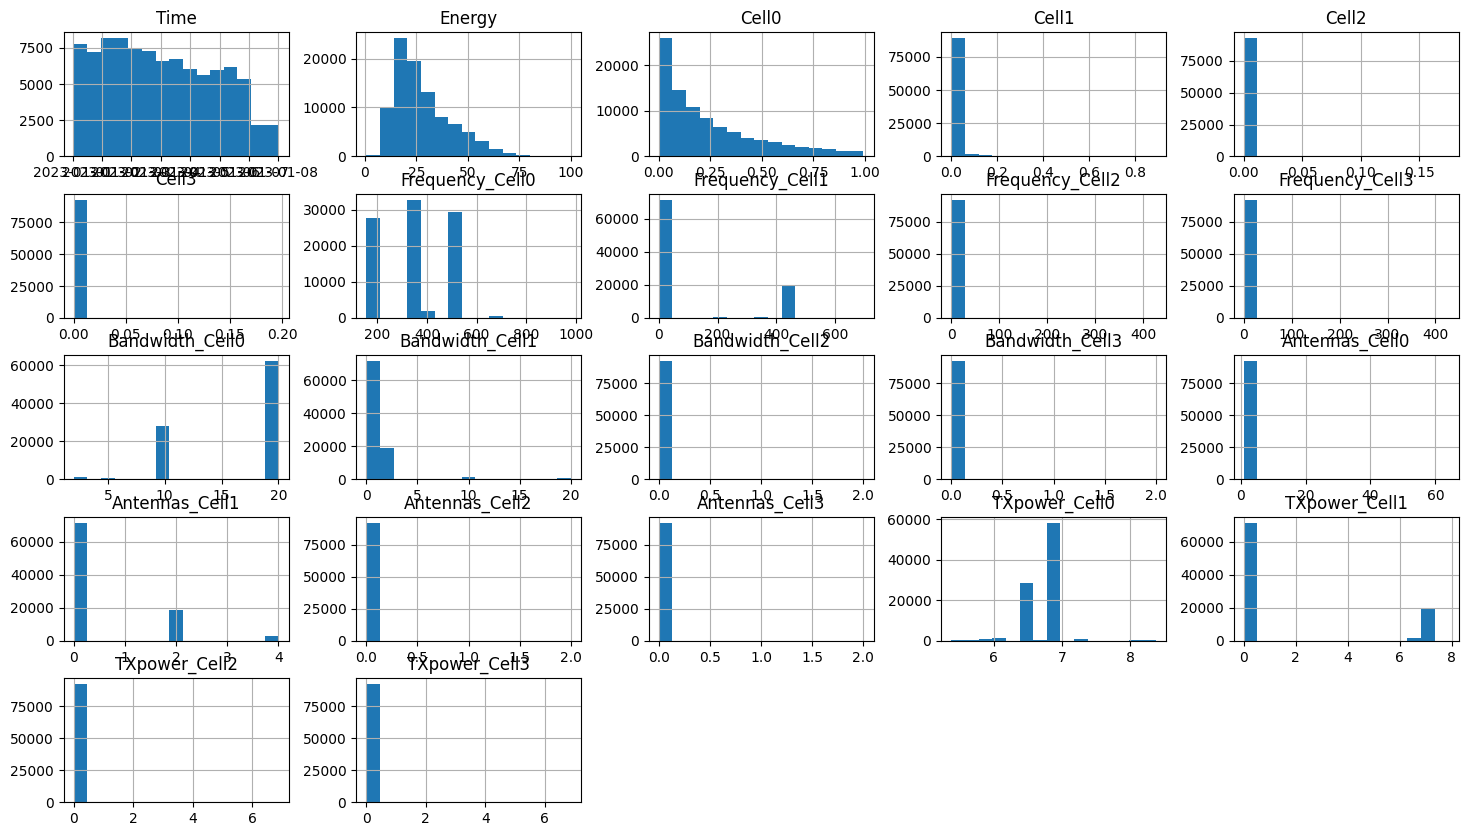

In [30]:
#Analyzing nuumerical variable
train_data[quantitative].hist(bins=15, figsize=(18, 10));

# Feature Engineering

In [31]:
train_data['Time'] = pd.to_datetime(train_data['Time'])
train_data['day'] = [i.day for i in train_data.Time]
train_data['day_of_year'] = [i.dayofyear for i in train_data.Time]
train_data['month'] = [i.month for i in train_data.Time]
train_data['hour'] = [i.hour for i in train_data.Time]
train_data['is_weekday'] = [i.isoweekday() for i in train_data.Time]

In [32]:
train_data.head()

,Time,BS,Energy,Cell0,Cell1,Cell2,Cell3,RUType_Cell0,RUType_Cell1,RUType_Cell2,...,Antennas_Cell3,TXpower_Cell0,TXpower_Cell1,TXpower_Cell2,TXpower_Cell3,day,day_of_year,month,hour,is_weekday
0,2023-01-01 01:00:00,B_0,64.275037,0.487936,0.0,0.0,0.0,Type1,Type1,Empty,...,0.0,6.875934,7.327504,0.0,0.0,1,1,1,1,7
1,2023-01-01 02:00:00,B_0,55.904335,0.344468,0.0,0.0,0.0,Type1,Type1,Empty,...,0.0,6.875934,7.327504,0.0,0.0,1,1,1,2,7
2,2023-01-01 03:00:00,B_0,57.698057,0.193766,0.0,0.0,0.0,Type1,Type1,Empty,...,0.0,6.875934,7.327504,0.0,0.0,1,1,1,3,7
3,2023-01-01 04:00:00,B_0,55.156951,0.222383,0.0,0.0,0.0,Type1,Type1,Empty,...,0.0,6.875934,7.327504,0.0,0.0,1,1,1,4,7
4,2023-01-01 05:00:00,B_0,56.053812,0.175436,0.0,0.0,0.0,Type1,Type1,Empty,...,0.0,6.875934,7.327504,0.0,0.0,1,1,1,5,7


In [33]:
def timestamp_to_sin_cos(dt):
    hour = dt.hour
    normalized_hour = hour / 24.0
    hour_theta = 2 * np.pi * normalized_hour
    hour_sin = np.sin(hour_theta)
    hour_cos = np.cos(hour_theta)
    return pd.Series({
    'hour_sin': hour_sin,
    'hour_cos': hour_cos,
})

# Apply the function to each row in the DataFrame
sin_cos_features = train_data['Time'].apply(timestamp_to_sin_cos)

# Concatenate the new features to the original DataFrame
train_data = pd.concat([train_data, sin_cos_features], axis=1)

In [34]:
train_data.head(3)

,Time,BS,Energy,Cell0,Cell1,Cell2,Cell3,RUType_Cell0,RUType_Cell1,RUType_Cell2,...,TXpower_Cell1,TXpower_Cell2,TXpower_Cell3,day,day_of_year,month,hour,is_weekday,hour_sin,hour_cos
0,2023-01-01 01:00:00,B_0,64.275037,0.487936,0.0,0.0,0.0,Type1,Type1,Empty,...,7.327504,0.0,0.0,1,1,1,1,7,0.258819,0.965926
1,2023-01-01 02:00:00,B_0,55.904335,0.344468,0.0,0.0,0.0,Type1,Type1,Empty,...,7.327504,0.0,0.0,1,1,1,2,7,0.500000,0.866025
2,2023-01-01 03:00:00,B_0,57.698057,0.193766,0.0,0.0,0.0,Type1,Type1,Empty,...,7.327504,0.0,0.0,1,1,1,3,7,0.707107,0.707107


In [35]:
'''
#  This can be particularly useful when the effect of the datetime column might be different for different categorical groups.
#Convert datetime column to numerical features (e.g., days since a reference date)
train_data['datetime_column'] = (train_data['Time'] - train_data['Time'].min()).dt.days
#test_data['datetime_column'] = (X_test['datetime_column'] - X_train['datetime_column'].min()).dt.days
# Convert datetime column to numerical features within categorical groups
for col in categorical_cols:
    min_date_per_group = X_train.groupby(col)['datetime_column'].min()
    X_test['datetime_column'] = (
        X_test.apply(lambda row: (row['datetime_column'] - min_date_per_group[row[col]]).days, axis=1)
    )
'''

"\n#  This can be particularly useful when the effect of the datetime column might be different for different categorical groups.\n#Convert datetime column to numerical features (e.g., days since a reference date)\ntrain_data['datetime_column'] = (train_data['Time'] - train_data['Time'].min()).dt.days\n#test_data['datetime_column'] = (X_test['datetime_column'] - X_train['datetime_column'].min()).dt.days\n# Convert datetime column to numerical features within categorical groups\nfor col in categorical_cols:\n    min_date_per_group = X_train.groupby(col)['datetime_column'].min()\n    X_test['datetime_column'] = (\n        X_test.apply(lambda row: (row['datetime_column'] - min_date_per_group[row[col]]).days, axis=1)\n    )\n"

In [36]:
#Searching for Duplicated or Quasi-constant features
sel = DropConstantFeatures(tol=0.99, variables=None)

sel.fit(train_data)

features_to_drop = list(sel.features_to_drop_)
print(features_to_drop)

['Cell2', 'Cell3', 'RUType_Cell2', 'RUType_Cell3', 'Mode_Cell0', 'Mode_Cell2', 'Mode_Cell3', 'Frequency_Cell2', 'Frequency_Cell3', 'Bandwidth_Cell2', 'Bandwidth_Cell3', 'Antennas_Cell2', 'Antennas_Cell3', 'TXpower_Cell2', 'TXpower_Cell3', 'month']


In [37]:
#Looking for Correlated Features
sel = DropCorrelatedFeatures(threshold=0.80,    # more than 80% = remove
                             method='pearson') # you can use other methods like kendall or spearman

sel.fit(train_data)

features_to_drop = features_to_drop + list(sel.features_to_drop_)
features_to_drop = list(set(features_to_drop))
print('Features to drop', sel.features_to_drop_)
print()
print('Correlated Feature Sets', sel.correlated_feature_sets_)

Features to drop {'Antennas_Cell1', 'Bandwidth_Cell2', 'day_of_year', 'Antennas_Cell2', 'TXpower_Cell1', 'Frequency_Cell3', 'Antennas_Cell3', 'TXpower_Cell3', 'Bandwidth_Cell3', 'Cell3', 'TXpower_Cell2'}

Correlated Feature Sets [{'Cell2', 'Cell3'}, {'TXpower_Cell1', 'Antennas_Cell1', 'Frequency_Cell1'}, {'Bandwidth_Cell2', 'Antennas_Cell2', 'Frequency_Cell3', 'Antennas_Cell3', 'TXpower_Cell3', 'Bandwidth_Cell3', 'Frequency_Cell2', 'TXpower_Cell2'}, {'day_of_year', 'day'}]


In [38]:
print(features_to_drop)

['Mode_Cell0', 'RUType_Cell2', 'Mode_Cell3', 'Bandwidth_Cell3', 'TXpower_Cell1', 'Antennas_Cell3', 'TXpower_Cell3', 'Frequency_Cell2', 'Cell3', 'TXpower_Cell2', 'Antennas_Cell1', 'Bandwidth_Cell2', 'day_of_year', 'Antennas_Cell2', 'month', 'Cell2', 'RUType_Cell3', 'Mode_Cell2', 'Frequency_Cell3']


In [39]:
train_data.head(2)

,Time,BS,Energy,Cell0,Cell1,Cell2,Cell3,RUType_Cell0,RUType_Cell1,RUType_Cell2,...,TXpower_Cell1,TXpower_Cell2,TXpower_Cell3,day,day_of_year,month,hour,is_weekday,hour_sin,hour_cos
0,2023-01-01 01:00:00,B_0,64.275037,0.487936,0.0,0.0,0.0,Type1,Type1,Empty,...,7.327504,0.0,0.0,1,1,1,1,7,0.258819,0.965926
1,2023-01-01 02:00:00,B_0,55.904335,0.344468,0.0,0.0,0.0,Type1,Type1,Empty,...,7.327504,0.0,0.0,1,1,1,2,7,0.500000,0.866025


In [40]:
train_data.drop(features_to_drop, axis=1, inplace=True)

In [41]:
train_data.drop(['Time'], axis = 1, inplace = True)

# Target Variable check

<Axes: ylabel='Density'>

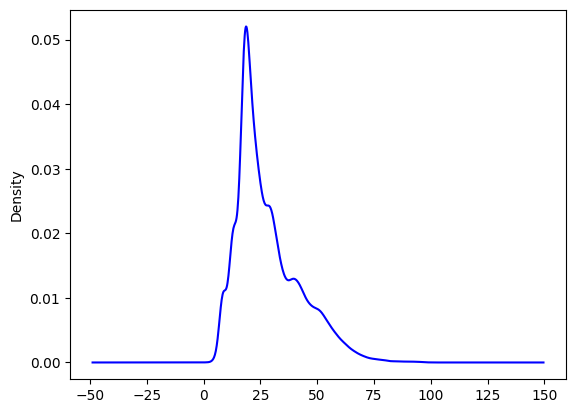

In [42]:
train_data['Energy'].plot.density(color='blue')

<Axes: xlabel='Energy', ylabel='Density'>

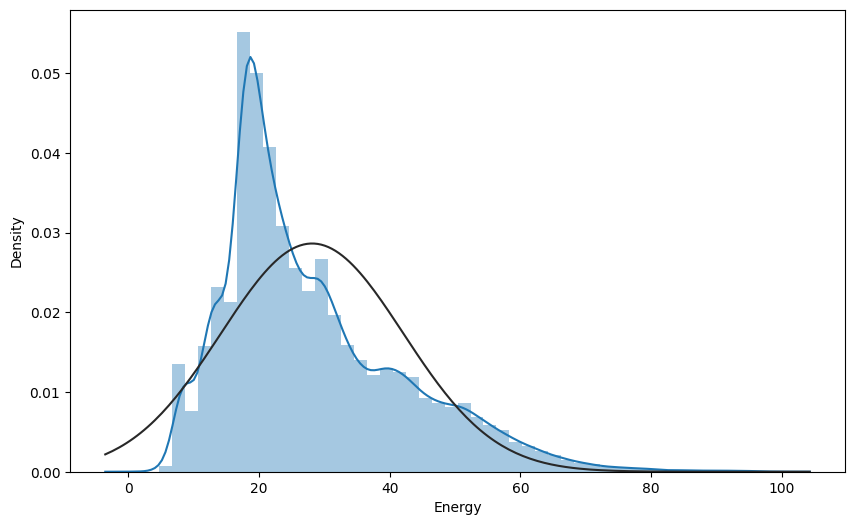

In [43]:
plt.figure(figsize=(10,6))
sns.distplot(train_data['Energy'], fit=st.norm)

In [44]:
train_data.head(3)

,BS,Energy,Cell0,Cell1,RUType_Cell0,RUType_Cell1,Mode_Cell1,Frequency_Cell0,Frequency_Cell1,Bandwidth_Cell0,Bandwidth_Cell1,Antennas_Cell0,TXpower_Cell0,day,hour,is_weekday,hour_sin,hour_cos
0,B_0,64.275037,0.487936,0.0,Type1,Type1,Mode2,365.0,426.98,20.0,2.0,4.0,6.875934,1,1,7,0.258819,0.965926
1,B_0,55.904335,0.344468,0.0,Type1,Type1,Mode2,365.0,426.98,20.0,2.0,4.0,6.875934,1,2,7,0.500000,0.866025
2,B_0,57.698057,0.193766,0.0,Type1,Type1,Mode2,365.0,426.98,20.0,2.0,4.0,6.875934,1,3,7,0.707107,0.707107


In [45]:
print(train_data['Energy'].skew())

1.0868815525085438


A skewness value greater than 1 or less than -1 indicates a highly skewed distribution

In [46]:
# Target variable is highly skewed, performing log transformation to reduce it
train_data['Energy_log']  = np.log(train_data['Energy']+1)

In [47]:
print(train_data['Energy'].skew())
print(train_data['Energy_log'].skew()) #task: model this

1.0868815525085438
-0.010387508085306474


A value between -0.5 and 0.5 indicates that the distribution is fairly symmetrical.

In [48]:
 train_data.drop(columns=['Energy_log'],inplace = True)

In [49]:
quantitative = []
qualitative = []
for i in train_data.columns:
    if train_data.dtypes[i] != 'object':
        quantitative.append(i)
    else:
        qualitative.append(i)
print('Numerical :: ', quantitative)
print('\nCatagorical :: ', qualitative)

Numerical ::  ['Energy', 'Cell0', 'Cell1', 'Frequency_Cell0', 'Frequency_Cell1', 'Bandwidth_Cell0', 'Bandwidth_Cell1', 'Antennas_Cell0', 'TXpower_Cell0', 'day', 'hour', 'is_weekday', 'hour_sin', 'hour_cos']

Catagorical ::  ['BS', 'RUType_Cell0', 'RUType_Cell1', 'Mode_Cell1']


# Model

In [50]:
# Separate features and target

features = train_data.drop(columns=['Energy'])
target = train_data['Energy']# Energy_log

In [51]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [52]:
# Preprocess categorical columns using label encoding
label_encoders = {}
for col in qualitative:
    print(col)
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

BS
RUType_Cell0
RUType_Cell1
Mode_Cell1


In [53]:
X_train.columns

Index(['BS', 'Cell0', 'Cell1', 'RUType_Cell0', 'RUType_Cell1', 'Mode_Cell1',
       'Frequency_Cell0', 'Frequency_Cell1', 'Bandwidth_Cell0',
       'Bandwidth_Cell1', 'Antennas_Cell0', 'TXpower_Cell0', 'day', 'hour',
       'is_weekday', 'hour_sin', 'hour_cos'],
      dtype='object')

## Scaling

In [54]:
X_train.head()

,BS,Cell0,Cell1,RUType_Cell0,RUType_Cell1,Mode_Cell1,Frequency_Cell0,Frequency_Cell1,Bandwidth_Cell0,Bandwidth_Cell1,Antennas_Cell0,TXpower_Cell0,day,hour,is_weekday,hour_sin,hour_cos
42091,318,0.306240,0.0,6,0,0,532.0,0.00,20.0,0.0,2.0,6.875934,6,1,5,0.258819,0.965926
27803,176,0.273149,0.0,0,1,2,365.0,426.98,20.0,2.0,2.0,6.875934,5,20,4,-0.866025,0.500000
40368,301,0.121560,0.0,7,0,0,189.0,0.00,10.0,0.0,2.0,6.427504,4,17,3,-0.965926,-0.258819
9254,820,0.075800,0.0,5,0,0,189.0,0.00,10.0,0.0,4.0,6.427504,4,19,3,-0.965926,0.258819
76007,656,0.845980,0.0,9,0,0,365.0,0.00,20.0,0.0,2.0,6.726457,3,19,2,-0.965926,0.258819


In [55]:
# Normalize numerical columns using StandardScaler/MinMaxScaler
#frequency, bandwidth, amtennas, txpower need to be scaled
numerical_cols = ['day', 'hour','is_weekday','RUType_Cell0','RUType_Cell1','Mode_Cell1','Frequency_Cell0',
                  'Frequency_Cell1','Bandwidth_Cell0','Bandwidth_Cell1', 'Antennas_Cell0','TXpower_Cell0']
scaler = MinMaxScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# XgBoost

In [56]:
import xgboost as xg

# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123, tree_method="hist", eval_metric= mean_absolute_error)


In [76]:
# Fitting the model
xgb_r.fit(X_train, y_train)
  
# Predict the model
y_pred = xgb_r.predict(X_test)

[16:46:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [77]:
y_pred

array([48.940033, 16.525352, 14.047662, ..., 39.32376 , 24.564337,
       33.251343], dtype=float32)

In [78]:

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error: {mape}")

Mean Absolute Percentage Error: 0.10180244649253929


In [79]:

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 2.6646528683433996


Text(0.5, 0, 'Permutation Importance')

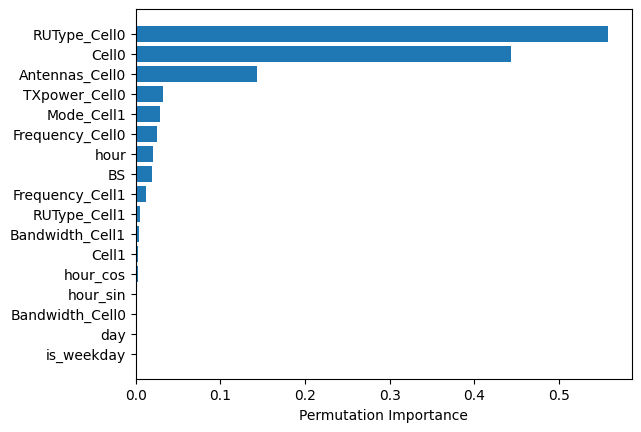

In [61]:

perm_importance = permutation_importance(xgb_r, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

# PoissonRegressor

In [62]:
from sklearn.linear_model import PoissonRegressor
poisson_reg = PoissonRegressor(alpha=1e-12, solver="newton-cholesky")
poisson_reg.fit(X_train, y_train)

PoissonRegressor(alpha=1e-12, solver='newton-cholesky')

In [63]:
from sklearn.metrics import mean_absolute_percentage_error
y_pred = poisson_reg.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error: {mape}")

Mean Absolute Percentage Error: 0.18984751860251334


# Ridge

In [64]:
from sklearn.linear_model import Ridge

In [65]:
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
y_pred = ridge_reg.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error: {mape}")

Mean Absolute Percentage Error: 0.17065413227568793


# AutoML

In [67]:
from pycaret.regression import *
exp_name = setup(train_data, target = 'Energy')
# modeling
best_model = compare_models()
# analyze best model
evaluate_model(best_model)
# predict
#predict = predict_model(best_model, data = test_set)
# save
save_model(best_model, 'my_saved_model')

,Description,Value
0,Session id,5487
1,Target,Energy
2,Target type,Regression
3,Original data shape,"(92629, 18)"
4,Transformed data shape,"(92629, 35)"
5,Transformed train set shape,"(64840, 35)"
6,Transformed test set shape,"(27789, 35)"
7,Numeric features,13
8,Categorical features,4
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,1.3080,4.3022,2.0739,0.9778,0.0745,0.0485,24.4950
et,Extra Trees Regressor,1.3323,4.4774,2.1157,0.9769,0.0762,0.0495,16.5680
xgboost,Extreme Gradient Boosting,1.4737,4.7312,2.1748,0.9755,0.0839,0.0582,6.2360
lightgbm,Light Gradient Boosting Machine,1.6585,5.8142,2.4111,0.9699,0.0931,0.0662,0.9460
dt,Decision Tree Regressor,1.7267,7.8226,2.7962,0.9596,0.0996,0.0624,0.7350
gbr,Gradient Boosting Regressor,1.9822,7.9336,2.8163,0.9590,0.1152,0.0833,6.5610
knn,K Neighbors Regressor,2.1417,9.8981,3.1457,0.9488,0.1229,0.0854,1.9520
lr,Linear Regression,2.5739,12.5065,3.5360,0.9354,0.1595,0.1188,0.9780
br,Bayesian Ridge,2.5736,12.5071,3.5360,0.9354,0.1594,0.1188,0.5390
ridge,Ridge Regression,2.5723,12.5110,3.5366,0.9353,0.1592,0.1187,0.4240


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

NameError: name 'test_set' is not defined

In [72]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='squared_error',
                      max_depth=None, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [74]:
y_pred = rf_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 1.4620576066944444


# Submission

In [158]:
power_consumption_prediction = pd.read_csv('power_consumption_prediction.csv')

In [159]:
power_consumption_prediction.shape

(26139, 4)

In [160]:
power_consumption_prediction.head()

,Time,BS,Energy,w
0,2023-01-01 06:00:00,B_0,NaN,1
1,2023-01-01 11:00:00,B_0,NaN,1
2,2023-01-01 12:00:00,B_0,NaN,1
3,2023-01-01 13:00:00,B_0,NaN,1
4,2023-01-01 23:00:00,B_0,NaN,1


In [161]:
print('Duplicate of power_consumption_prediction', power_consumption_prediction.duplicated().sum())

Duplicate of power_consumption_prediction 0


In [162]:
from copy import deepcopy
backup = deepcopy(power_consumption_prediction)

In [163]:

w = power_consumption_prediction.w.tolist()
power_consumption_prediction.drop(['Energy','w'],axis = 1, inplace = True)

In [164]:
power_consumption_prediction['Time'] = pd.to_datetime(power_consumption_prediction['Time'])

In [165]:
cell_level_with_energy_test = pd.merge(power_consumption_prediction, cell_level_data_pivot, on= ['BS', 'Time'], how = 'left')

In [166]:
test_data = pd.merge(cell_level_with_energy_test, base_station_info_pivot, on= ['BS'], how = 'left')

In [167]:
for column in test_data.columns:
    if 'Frequency' in column or 'Bandwidth' in column or 'TXpower' in column or 'Antennas' in column:
        test_data[column] = test_data[column].astype(float)
		
#train_data.fillna(0, inplace = True)
for i in test_data.columns:
    if test_data.dtypes[i] != 'object':
        test_data[i].fillna(0, inplace = True)
    else:
        test_data[i].fillna('Empty', inplace = True)

In [168]:
test_data['day'] = [i.day for i in test_data.Time]
test_data['day_of_year'] = [i.dayofyear for i in test_data.Time]
test_data['month'] = [i.month for i in test_data.Time]
test_data['hour'] = [i.hour for i in test_data.Time]
test_data['is_weekday'] = [i.isoweekday() for i in test_data.Time]

In [169]:
# Apply the function to each row in the DataFrame
sin_cos_features = test_data['Time'].apply(timestamp_to_sin_cos)

# Concatenate the new features to the original DataFrame
test_data = pd.concat([test_data, sin_cos_features], axis=1)

In [170]:
print(features_to_drop)

['Mode_Cell0', 'RUType_Cell2', 'Mode_Cell3', 'Bandwidth_Cell3', 'TXpower_Cell1', 'Antennas_Cell3', 'TXpower_Cell3', 'Frequency_Cell2', 'Cell3', 'TXpower_Cell2', 'Antennas_Cell1', 'Bandwidth_Cell2', 'day_of_year', 'Antennas_Cell2', 'month', 'Cell2', 'RUType_Cell3', 'Mode_Cell2', 'Frequency_Cell3']


In [171]:
train_data.columns, test_data.columns

(Index(['BS', 'Energy', 'Cell0', 'Cell1', 'RUType_Cell0', 'RUType_Cell1',
        'Mode_Cell1', 'Frequency_Cell0', 'Frequency_Cell1', 'Bandwidth_Cell0',
        'Bandwidth_Cell1', 'Antennas_Cell0', 'TXpower_Cell0', 'day', 'hour',
        'is_weekday', 'hour_sin', 'hour_cos'],
       dtype='object'),
 Index(['Time', 'BS', 'Cell0', 'Cell1', 'Cell2', 'Cell3', 'RUType_Cell0',
        'RUType_Cell1', 'RUType_Cell2', 'RUType_Cell3', 'Mode_Cell0',
        'Mode_Cell1', 'Mode_Cell2', 'Mode_Cell3', 'Frequency_Cell0',
        'Frequency_Cell1', 'Frequency_Cell2', 'Frequency_Cell3',
        'Bandwidth_Cell0', 'Bandwidth_Cell1', 'Bandwidth_Cell2',
        'Bandwidth_Cell3', 'Antennas_Cell0', 'Antennas_Cell1', 'Antennas_Cell2',
        'Antennas_Cell3', 'TXpower_Cell0', 'TXpower_Cell1', 'TXpower_Cell2',
        'TXpower_Cell3', 'day', 'day_of_year', 'month', 'hour', 'is_weekday',
        'hour_sin', 'hour_cos'],
       dtype='object'))

In [172]:

#test_data['datetime_column'] = (test_data['Time'] - test_data['Time'].min()).dt.days

test_data.drop(features_to_drop, axis=1, inplace=True)


test_data.drop(['Time'], axis = 1, inplace = True)

# Preprocess categorical columns using label encoding


for col, le in label_encoders.items():
    try:
        test_data[col] = le.transform(test_data[col])
    except:
        le = LabelEncoder()
        test_data[col] = le.fit_transform(test_data[col])

In [173]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
BS,26139.0,467.671602,273.442888,0.000000,234.000000,4.600000e+02,692.000000,1017.000000
Cell0,26139.0,0.234468,0.234953,0.000000,0.052924,1.467000e-01,0.343260,0.993628
Cell1,26139.0,0.005545,0.031953,0.000000,0.000000,0.000000e+00,0.000000,0.691038
RUType_Cell0,26139.0,5.221202,3.275599,0.000000,2.000000,6.000000e+00,8.000000,11.000000
RUType_Cell1,26139.0,0.242205,0.577315,0.000000,0.000000,0.000000e+00,0.000000,6.000000
Mode_Cell1,26139.0,0.407514,0.804360,0.000000,0.000000,0.000000e+00,0.000000,2.000000
Frequency_Cell0,26139.0,389.779345,167.525670,155.600000,189.000000,3.650000e+02,532.000000,979.998000
Frequency_Cell1,26139.0,85.512548,170.643274,0.000000,0.000000,0.000000e+00,0.000000,697.002000
Bandwidth_Cell0,26139.0,15.553502,5.775693,2.000000,10.000000,2.000000e+01,20.000000,20.000000
Bandwidth_Cell1,26139.0,0.647003,2.118983,0.000000,0.000000,0.000000e+00,0.000000,20.000000


In [174]:
test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

In [175]:
test_data.head(3)

,BS,Cell0,Cell1,RUType_Cell0,RUType_Cell1,Mode_Cell1,Frequency_Cell0,Frequency_Cell1,Bandwidth_Cell0,Bandwidth_Cell1,Antennas_Cell0,TXpower_Cell0,day,hour,is_weekday,hour_sin,hour_cos
0,0,0.189872,0.0,0.0,0.2,1.0,0.254004,0.612595,1.0,0.1,0.047619,0.499226,0.0,0.260870,1.0,1.000000e+00,6.123234e-17
1,0,0.522096,0.0,0.0,0.2,1.0,0.254004,0.612595,1.0,0.1,0.047619,0.499226,0.0,0.478261,1.0,2.588190e-01,-9.659258e-01
2,0,0.439968,0.0,0.0,0.2,1.0,0.254004,0.612595,1.0,0.1,0.047619,0.499226,0.0,0.521739,1.0,1.224647e-16,-1.000000e+00


In [176]:
energy_pred = rf_reg.predict(test_data)

In [177]:
len(energy_pred.tolist())


26139

In [178]:
energy_pred

array([62.59940209, 77.44394619, 72.52167414, ..., 23.90881913,
       23.89835575, 23.89387145])

In [179]:
s = energy_pred.tolist()

In [180]:
min(s)

5.269058295809998

In [181]:
max(s)

94.08669656069993

In [182]:
backup['ID'] = backup['Time'] + '_' +  backup['BS']

In [183]:
backup['Energy'] = s

In [184]:
backup

,Time,BS,Energy,w,ID
0,2023-01-01 06:00:00,B_0,62.599402,1,2023-01-01 06:00:00_B_0
1,2023-01-01 11:00:00,B_0,77.443946,1,2023-01-01 11:00:00_B_0
2,2023-01-01 12:00:00,B_0,72.521674,1,2023-01-01 12:00:00_B_0
3,2023-01-01 13:00:00,B_0,75.458894,1,2023-01-01 13:00:00_B_0
4,2023-01-01 23:00:00,B_0,79.931241,1,2023-01-01 23:00:00_B_0
...,...,...,...,...,...
26134,2023-01-02 19:00:00,B_1019,24.022422,5,2023-01-02 19:00:00_B_1019
26135,2023-01-02 20:00:00,B_1019,23.940209,5,2023-01-02 20:00:00_B_1019
26136,2023-01-02 21:00:00,B_1019,23.908819,5,2023-01-02 21:00:00_B_1019
26137,2023-01-02 22:00:00,B_1019,23.898356,5,2023-01-02 22:00:00_B_1019


In [185]:
backup.drop(['Time','BS','w'], axis =1, inplace = True)

In [186]:
popped_col = backup.pop("ID")
backup.insert(0, popped_col.name, popped_col)

In [187]:
backup.to_csv('submission_5.csv', index = False)

In [188]:
backup

,ID,Energy
0,2023-01-01 06:00:00_B_0,62.599402
1,2023-01-01 11:00:00_B_0,77.443946
2,2023-01-01 12:00:00_B_0,72.521674
3,2023-01-01 13:00:00_B_0,75.458894
4,2023-01-01 23:00:00_B_0,79.931241
...,...,...
26134,2023-01-02 19:00:00_B_1019,24.022422
26135,2023-01-02 20:00:00_B_1019,23.940209
26136,2023-01-02 21:00:00_B_1019,23.908819
26137,2023-01-02 22:00:00_B_1019,23.898356


In [ ]:
backup.shape

In [ ]:
backup.columns

In [ ]:
ID,Energy